# Bayesian neural network

First, we load the modules we need:

In [12]:
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd

from coinem.model import AbstractModel
from coinem.dataset import Dataset

# Pyplot for plots.
import matplotlib.pyplot as plt 

from jax import vmap

## Model

In [13]:
@dataclass
class BayesNN(AbstractModel):
    """Base class for p(θ, x)."""

    num_datapoints: int
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"], batch: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (2,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        X = batch.X # [Batchsize, 28, 28]
        y = batch.y.squeeze() # [Batchsize, 1]


        # Compute priors:
        log_prior_w = tfd.Normal(0.0, jnp.exp(2.0 * theta["alpha"])).log_prob(latent["w"]).sum()
        log_prior_v = tfd.Normal(0.0, jnp.exp(2.0 * theta["beta"])).log_prob(latent["v"]).sum()


        def _compute_log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten())))) 


        log_nn = jax.vmap(_compute_log_nn)(X)
        log_lik = vmap(lambda v, l : v[l])(log_nn, y).sum()


        # Compute log-probability.
        return  (log_lik * self.num_datapoints/batch.n + log_prior_w + log_prior_v) # log p(y|x) + log p(x|theta) 

Next, we load and curate the dataset:

In [14]:
#@title Load, subsample, and normalize MNIST dataset.
import numpy as np

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries so that they have mean zero and unit standard 
# across the dataset:'''
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

from coinem.dataset import Dataset

data = Dataset(jnp.array(itrain), jnp.array(ltrain).reshape(-1, 1))

We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

We can now run the algorithms using an 80/20 training/test split of the data:

In [15]:
# Set approximation parameters:
h = 1e-1 # Step-size. 
K = 1000  # Number of steps.
N = 100  # Number of particles.

key = jr.PRNGKey(42)

# Initialize parameters:
alpha0 = jnp.array([0.0])
beta0 = jnp.array([0.0])
w0 = jnp.exp(alpha0) * jr.normal(key, (N, 40,  28**2))  # Input layer weights.
v0 = jnp.exp(beta0) * jr.normal(key, (N, 2, 40))  # Output layer weights.

th0 = {'alpha': alpha0, 'beta': beta0}
X0 = {'w': w0, 'v': v0}

In [20]:
from coinem.zoo import coin_svgd, pgd, adam_svgd, soul
model = BayesNN(data.n)

x_coin, theta_coin = coin_svgd(model, data, X0, th0, K, alpha = 100.0)
x_pgd, theta_pgd = pgd(model, data, X0, th0, K, latent_step_size=1e-3, theta_step_size=1e-3)
x_adam, theta_adam = adam_svgd(model, data, X0, th0, K, latent_step_size=1e-1, theta_step_size=1e-1)
x_soul, theta_soul = soul(model, data, X0, th0, K, latent_step_size=1e-3, theta_step_size=1e-3)

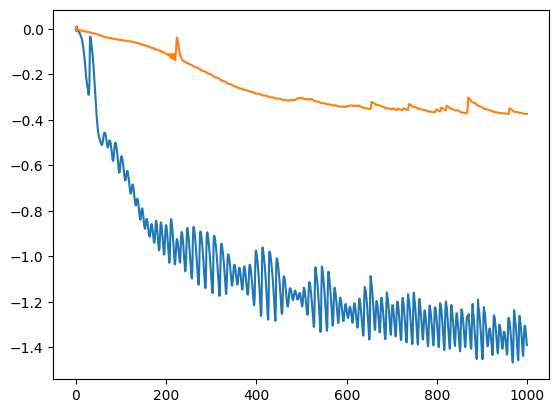

In [21]:
plt.plot(theta_coin["alpha"])
plt.plot(theta_coin["beta"])

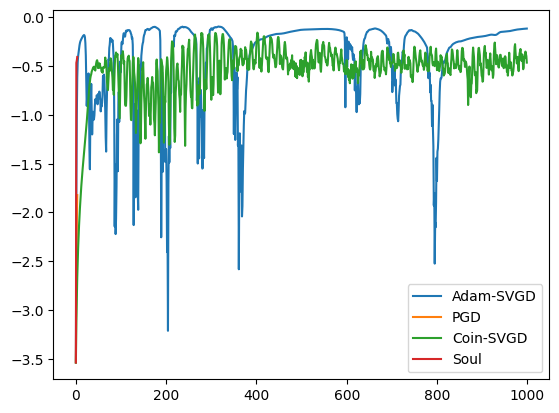

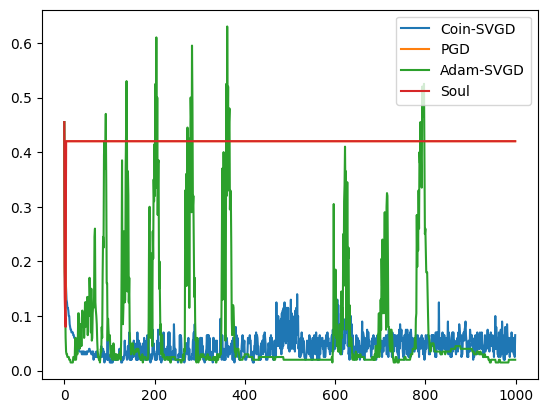

In [22]:
def log_pointwise_predrictive_density(model, latent_particles, images, labels):
    """Returns LPPD for set of (test) images and labels."""

    def _latent_cal(latent):


        def _compute_log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_compute_log_nn)(images)


        return _log_nn_vec(images)
    
    s = jax.vmap(_latent_cal)(latent_particles).mean(0)
    return vmap(lambda v, l : v[l])(s, labels).mean()




def _predict(model, latent_particles, images):
    """Returns LPPD for set of (test) images and labels."""

    def _latent_cal(latent):

        def _compute_log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_compute_log_nn)(images)


        return _log_nn_vec(images)
    
    s = jax.vmap(_latent_cal)(latent_particles).mean(0)
    return jnp.argmax(s, axis=1)


def test_error(model, latent_particles, images, labels):
    """Returns fraction of misclassified images in test set."""
    return jnp.abs(labels.squeeze() - _predict(model, latent_particles, images)).mean()

plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_adam), label="Adam-SVGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd), label="PGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_coin), label="Coin-SVGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul), label="Soul")
plt.legend()
plt.show()

plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_coin), label="Coin-SVGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd), label="PGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_adam), label="Adam-SVGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul), label="Soul")
plt.legend()
plt.show()